<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, vstack
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve


In [17]:
# avoid decoding problems
df = pd.read_csv(r"D:\AppliedAI\Homework-n-Assignments\# 20 Quora\train.csv")
df.sort_values(by=['id'])
df = df.head(70000)
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [18]:
print (df.shape)
df.head()


(70000, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [19]:
df_without_qid = df.drop(columns=['qid1', 'qid2','is_duplicate'])
df_without_qid.head()

,id,question1,question2
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [20]:

if os.path.isfile(r'D:\AppliedAI\Homework-n-Assignments\# 20 Quora\nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    dfnlp = dfnlp.head(70000)
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile(r'D:\AppliedAI\Homework-n-Assignments\# 20 Quora\df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    dfppro = dfppro.head(70000)

else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

    
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
#df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


In [21]:
print (df1.shape)
df1.head()


(70000, 17)


,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [22]:
print (df2.shape)
df2.head()

(70000, 12)


,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [23]:
df4 =pd.merge(df1, df2, on='id')
df4.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [24]:
df_final =pd.merge(df_without_qid, df4, on='id')
#print (df_final.shape)


In [25]:
df_final_train, df_final_test = train_test_split(df_final, test_size=0.33, shuffle=False)

#print (df_final_train.shape)


In [26]:
q1_train = df_final_train['question1'].values
q1_test = df_final_test['question1'].values

q2_train = df_final_train['question2'].values
q2_test = df_final_test['question2'].values

y_train = df_final_train['is_duplicate'].values
y_test = df_final_test['is_duplicate'].values

In [27]:
q_train = np.concatenate([q1_train,q2_train])
q_test = np.concatenate([q1_test,q2_test])

print (q_train.shape)
print (q_test.shape)

(93800,)
(46200,)


In [28]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

lst_train_q1=[]
lst_test_q1=[]
lst_of_lst_train_q1 = []
lst_of_lst_test_q1 = []

for sentance in tqdm(q1_train):
    lst_train_q1.append(sentance.strip())
for sentance in tqdm(lst_train_q1):
    lst_of_lst_train_q1.append(sentance.split())

for sent in tqdm(q1_test):
    lst_test_q1.append(sent.strip())
for sent in tqdm(lst_test_q1):
    lst_of_lst_test_q1.append(sent.split())
    
    
w2v_model_self_taught_train_q1=Word2Vec(lst_of_lst_train_q1,min_count=1,size=50, workers=4)
w2v_words_train_q1 = list(w2v_model_self_taught_train_q1.wv.vocab)

###################################################################
lst_train_q2=[]
lst_test_q2=[]
lst_of_lst_train_q2 = []
lst_of_lst_test_q2 = []

for sentance in tqdm(q2_train):
    lst_train_q2.append(sentance.strip())
for sentance in tqdm(lst_train_q2):
    lst_of_lst_train_q2.append(sentance.split())

for sent in tqdm(q2_test):
    lst_test_q2.append(sent.strip())
for sent in tqdm(lst_test_q2):
    lst_of_lst_test_q2.append(sent.split())
    
    
w2v_model_self_taught_train_q2=Word2Vec(lst_of_lst_train_q1,min_count=1,size=50, workers=4)
w2v_words_train_q2 = list(w2v_model_self_taught_train_q2.wv.vocab)

100%|████████████████████████████████████████████████████████████████████████| 23100/23100 [00:00<00:00, 643396.41it/s]


In [29]:
tf_idf_vect_q1 = TfidfVectorizer(min_df=4,ngram_range=(1,3),max_features=2500)
tfidf_q1_train = tf_idf_vect_q1.fit_transform(q1_train)
dictionary_q1 = dict(zip(tf_idf_vect_q1.get_feature_names(), list(tf_idf_vect_q1.idf_)))
tfidfw2v_q1 = tf_idf_vect_q1.get_feature_names() 
tfidf_q1_test = tf_idf_vect_q1.transform(q1_test)

####################

tf_idf_vect_q2 = TfidfVectorizer(min_df=4,ngram_range=(1,3),max_features=2500)
tfidf_q2_train = tf_idf_vect_q2.fit(q2_train)
dictionary_q2 = dict(zip(tf_idf_vect_q2.get_feature_names(), list(tf_idf_vect_q2.idf_)))
tfidfw2v_q2 = tf_idf_vect_q2.get_feature_names()
tfidf_q2_test = tf_idf_vect_q2.transform(q2_test)


In [30]:
#tf_idf_vect = TfidfVectorizer(min_df=4,ngram_range=(1,3),max_features=2500)
#tfidf_q1_train = tf_idf_vect.fit_transform(q1_train)
#tfidf_q1_test = tf_idf_vect.transform(q1_test)

#tfidf_q2_train = tf_idf_vect.fit_transform(q2_train)
#tfidf_q2_test = tf_idf_vect.transform(q2_test)

In [31]:
tfidf_w2v_q1_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent4 in tqdm(lst_of_lst_train_q1): # for each review/sentence 
    sent_vec4 = np.zeros(50) # as word vectors are of zero length
    weight_sum4 =0; # num of words with a valid vector in the sentence/review
    for word4 in sent4: # for each word in a review/sentence
        if word4 in w2v_words_train_q1 and word4 in tfidfw2v_q1:
            vec4 = w2v_model_self_taught_train_q1.wv[word4]
            tf_idf_train_q1 = dictionary_q1[word4]*(sent4.count(word4)/len(sent4))
            sent_vec4 += (vec4 * tf_idf_train_q1)
            weight_sum4 += tf_idf_train_q1
    if weight_sum4 != 0:
        sent_vec4 /= weight_sum4
    tfidf_w2v_q1_train.append(sent_vec4)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 46900/46900 [01:07<00:00, 699.64it/s]


In [32]:
tfidf_w2v_q1_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent5 in tqdm(lst_of_lst_test_q1): # for each review/sentence 
    sent_vec5 = np.zeros(50) # as word vectors are of zero length
    weight_sum5 =0; # num of words with a valid vector in the sentence/review
    for word5 in sent5: # for each word in a review/sentence
        if word5 in w2v_words_train_q1 and word5 in tfidfw2v_q1:
            vec5 = w2v_model_self_taught_train_q1.wv[word5]
            tf_idf_test_q1 = dictionary_q1[word5]*(sent5.count(word5)/len(sent5))
            sent_vec5 += (vec5 * tf_idf_test_q1)
            weight_sum5 += tf_idf_test_q1
    if weight_sum5 != 0:
        sent_vec5 /= weight_sum5
    tfidf_w2v_q1_test.append(sent_vec5)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 23100/23100 [00:45<00:00, 509.46it/s]


In [33]:
tfidf_w2v_q2_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent2 in tqdm(lst_of_lst_train_q2): # for each review/sentence 
    sent_vec2 = np.zeros(50) # as word vectors are of zero length
    weight_sum2 =0; # num of words with a valid vector in the sentence/review
    for word2 in sent2: # for each word in a review/sentence
        if word2 in w2v_words_train_q2 and word4 in tfidfw2v_q2:
            vec2 = w2v_model_self_taught_train_q2.wv[word2]
            tf_idf_train_q2 = dictionary_q2[word2]*(sent2.count(word2)/len(sent2))
            sent_vec2 += (vec2 * tf_idf_train_q2)
            weight_sum2 += tf_idf_train_q2
    if weight_sum2 != 0:
        sent_vec2 /= weight_sum2
    tfidf_w2v_q2_train.append(sent_vec2)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 46900/46900 [01:24<00:00, 551.88it/s]


In [34]:
tfidf_w2v_q2_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent3 in tqdm(lst_of_lst_test_q2): # for each review/sentence 
    sent_vec3 = np.zeros(50) # as word vectors are of zero length
    weight_sum3 =0; # num of words with a valid vector in the sentence/review
    for word3 in sent3: # for each word in a review/sentence
        if word3 in w2v_words_train_q2 and word5 in tfidfw2v_q2:
            vec3 = w2v_model_self_taught_train_q2.wv[word3]
            tf_idf_test_q2 = dictionary_q2[word3]*(sent3.count(word3)/len(sent3))
            sent_vec3 += (vec3 * tf_idf_test_q2)
            weight_sum3 += tf_idf_test_q2
    if weight_sum3 != 0:
        sent_vec3 /= weight_sum3
    tfidf_w2v_q2_test.append(sent_vec3)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 23100/23100 [00:44<00:00, 524.40it/s]


In [35]:
q1_train_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_q1_train)
q1_test_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_q1_test)

q2_train_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_q2_train)
q2_test_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_q2_test)

In [38]:
#https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe
#https://www.researchgate.net/post/How_to_append_TF-IDF_vector_into_pandas_dataframe

#q1_train_std_df = pd.DataFrame(q1_train_std.toarray())
#q1_test_std_df = pd.DataFrame(q1_test_std.toarray())
                               
#q2_train_std_df = pd.DataFrame(q2_train_std.toarray())
#q2_test_std_df = pd.DataFrame(q2_test_std.toarray())

q1_train_std_df = pd.DataFrame(q1_train_std)
q1_test_std_df = pd.DataFrame(q1_test_std)
                               
q2_train_std_df = pd.DataFrame(q2_train_std)
q2_test_std_df = pd.DataFrame(q2_test_std)

In [39]:
from scipy.sparse import coo_matrix, hstack
import scipy.sparse as ss

train_after_dropping = df_final_train.drop(['id','question1','question2','is_duplicate'],axis=1)
print (train_after_dropping.shape)
X_train = pd.concat([train_after_dropping, q2_train_std_df,q1_train_std_df], axis=1)

test_after_dropping = df_final_test.drop(['id','question1','question2','is_duplicate'],axis=1)
X_test1 = pd.concat([q2_test_std_df,q1_test_std_df],axis=1)
X_test = ss.hstack([test_after_dropping,X_test1])

print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)



(46900, 26)
Number of data points in train data : (46900, 126)
Number of data points in test data : (23100, 126)


In [40]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.626226012793177 Class 1:  0.37377398720682303
---------- Distribution of output variable in train data ----------
Class 0:  0.36978354978354977 Class 1:  0.36978354978354977


In [41]:


# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8888108603784698


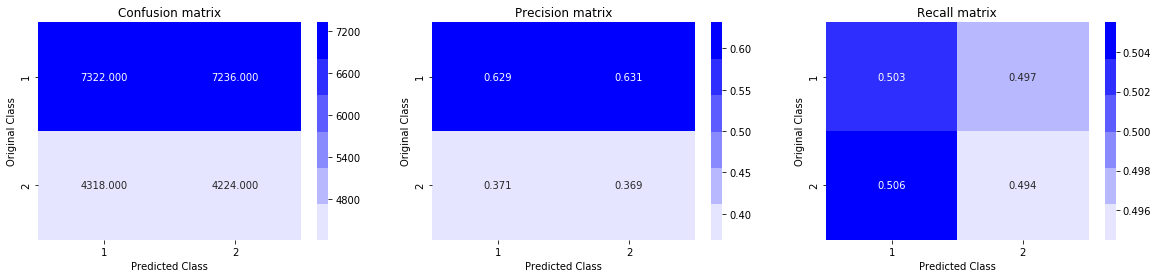

In [42]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 XGBoost </h2>

In [44]:
print (type(X_train))
print (type(X_test))
X_test = pd.DataFrame(X_test.toarray())
print (type(X_test))
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()


<class 'pandas.core.frame.DataFrame'>
<class 'scipy.sparse.coo.coo_matrix'>
<class 'pandas.core.frame.DataFrame'>


In [45]:
print (type(X_train))
print (type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [46]:
from xgboost import XGBClassifier

from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import warnings
warnings.filterwarnings("ignore")


XGB = XGBClassifier(booster='gbtree',objective = 'binary:logistic',eval_metric= 'logloss')

param_grid = {'max_depth':[3,9,11],'n_estimators':[50,100,300,500]}
xgboost_GBDT = RandomizedSearchCV(XGB,param_grid,cv=3, verbose=2)
xgboost_GBDT.fit(X_train,y_train)
xgboost_GBDT.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=100, max_depth=3 ...................................
[CV] .................... n_estimators=100, max_depth=3, total=  20.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s remaining:    0.0s


[CV] n_estimators=100, max_depth=3 ...................................
[CV] .................... n_estimators=100, max_depth=3, total=  19.7s
[CV] n_estimators=100, max_depth=3 ...................................
[CV] .................... n_estimators=100, max_depth=3, total=  19.6s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ..................... n_estimators=50, max_depth=3, total=  10.2s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ..................... n_estimators=50, max_depth=3, total=  10.2s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ..................... n_estimators=50, max_depth=3, total=  10.1s
[CV] n_estimators=50, max_depth=11 ...................................
[CV] .................... n_estimators=50, max_depth=11, total=  34.2s
[CV] n_estimators=50, max_depth=11 ...................................
[CV] .................... n_estimators=50, max_depth=11, total=  34.2s
[CV] n

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 49.3min finished


{'n_estimators': 300, 'max_depth': 9}

In [47]:
from xgboost import XGBClassifier

from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import warnings

besthyperpara_xgboost = XGBClassifier(booster='gbtree',objective = 'binary:logistic',eval_metric= 'logloss',max_depth=9,n_estimators=300)
besthyperpara_xgboost.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(besthyperpara_xgboost, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y_xgboo = sig_clf.predict_proba(X_test)

In [48]:
print (log_loss(y_test, predict_y_xgboo, labels=besthyperpara_xgboost.classes_, eps=1e-15))

0.35881632092238686


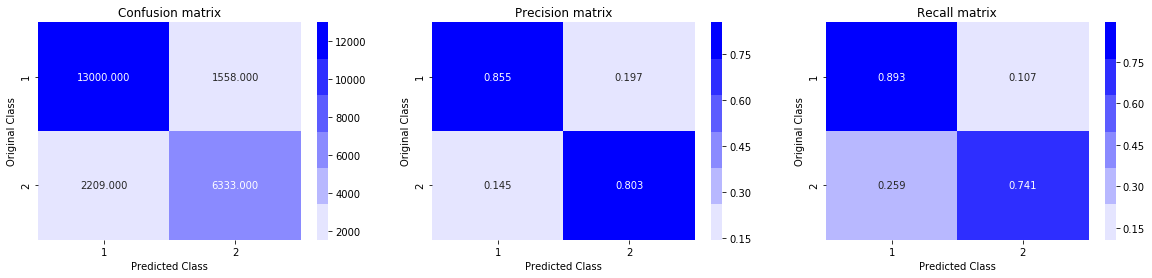

In [49]:
predicted_y_xgboo =np.argmax(predict_y_xgboo,axis=1)
plot_confusion_matrix(y_test, predicted_y_xgboo)